<a href="https://colab.research.google.com/github/juyeeeeon/pytorch_newbie/blob/main/5_%EC%9D%B8%EA%B3%B5%EC%8B%A0%EA%B2%BD%EB%A7%9D.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **5.1> 다층 퍼셉트론**

# **5.1.1) 선형 회귀 (단층 퍼셉트론)**



In [ ]:
import torch
import torch.nn as nn
from matplotlib import pyplot as plt

x = torch.FloatTensor(range(5)).unsqueeze(1)
y = 2*x + torch.rand(5,1)

print(x)
print(y)

tensor([[0.],
        [1.],
        [2.],
        [3.],
        [4.]])
tensor([[0.6841],
        [2.2549],
        [4.7262],
        [6.9644],
        [8.9893]])


In [ ]:
class LinearRegressor(nn.Module):
  def __init__(self):
    super().__init__()
    # 선형 회귀 모델 y = wx+b를 nn.Linear(N, M, bias=True)로 표현 가능
    # N : 입력 변수의 개수(x의 크기), M : 출력 변수의 개수(y의 크기기)
    self.fc = nn.Linear(1,1,bias=True)

  def forward(self, x):
    y = self.fc(x)

    return y

In [ ]:
model = LinearRegressor()
learning_rate = 1e-3
criterion = nn.MSELoss() #MSE를 손실 함수로 사용
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

In [ ]:
loss_stack = []
for epoch in range(1001):
  optimizer.zero_grad()

  y_hat = model(x)
  loss = criterion(y_hat, y)

  loss.backward()
  optimizer.step()
  loss_stack.append(loss.item())

  if epoch%100 == 0:
    print(f'Epoch {epoch} : {loss.item()}')

Epoch 0 : 24.083770751953125
Epoch 100 : 1.6535499095916748
Epoch 200 : 0.14420923590660095
Epoch 300 : 0.0426250621676445
Epoch 400 : 0.03577049821615219
Epoch 500 : 0.03529244661331177
Epoch 600 : 0.0352453887462616
Epoch 700 : 0.035228971391916275
Epoch 800 : 0.03521613031625748
Epoch 900 : 0.035204801708459854
Epoch 1000 : 0.03519483283162117


In [ ]:
with torch.no_grad():
  y_hat = model(x)

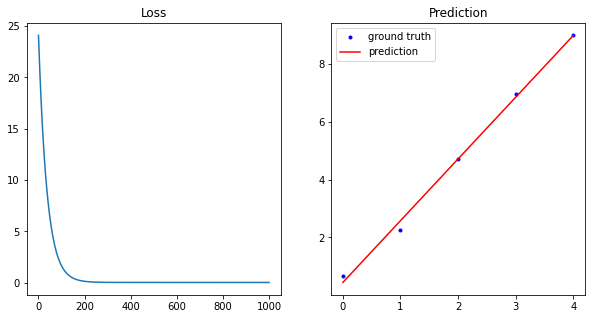

In [ ]:
plt.figure(figsize=(10,5))
plt.subplot(121)
plt.plot(loss_stack)
plt.title("Loss")

plt.subplot(122)
plt.plot(x, y, '.b')
plt.plot(x, y_hat, 'r-')
plt.legend(['ground truth', 'prediction'])
plt.title("Prediction")
plt.show()

# **5.1.2) 집값 예측하기**

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
import torch
from torch import nn, optim
from torch.utils.data import DataLoader, Dataset
import torch.nn.functional as F
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt

In [ ]:
df = pd.read_csv('../data/reg.csv', index_col=[0])

In [ ]:
X = df.drop('Price', axis=1).to_numpy()
Y = df['Price'].to_numpy().reshape((-1, 1))

In [ ]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.5)

In [ ]:
class TensorData(Dataset):
  def __init__(self, x_data, y_data):
    self.x_data = torch.FloatTensor(x_data)
    self.y_data = torch.FloatTensor(y_data)
    self.len = self.y_data.shape[0]

  def __getitem__(self, index):
    return self.x_data[index], self.y_data[index]
  
  def __len__(self):
    return self.len

In [ ]:
trainsets = TensorData(X_train, Y_train)
trainloader = torch.utils.data.DataLoader(trainsets, batch_size=32, shuffle=True)

testsets = TensorData(X_test, Y_test)
testloader = torch.utils.data.DataLoader(testsets, batch_size=32, shuffle=False)

In [ ]:
class Regressor(nn.Module):
  def __init__(self):
    super().__init__()
    self.fc1 = nn.Linear(13, 50, bias=True)
    self.fc2 = nn.Linear(50, 30, bias=True)
    self.fc3 = nn.Linear(30, 1, bias=True)
    self.dropout = nn.Dropout(0.5)

  def forward(self, x):
    x = F.relu(self.fc1(x))
    x = self.dropout(F.relu(self.fc2(x)))
    x = F.relu(self.fc3(x))
    return x

In [ ]:
model = Regressor()
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-7)

In [ ]:
loss_ = []
n = len(trainloader)
for epoch in range(400):
  running_loss = 0.0
  for data in trainloader:
    inputs, values = data
    optimizer.zero_grad()
    outputs = model(inputs)
    loss = criterion(outputs, values)
    loss.backward()
    optimizer.step()
    running_loss += loss.item()

  loss_.append(running_loss/n)

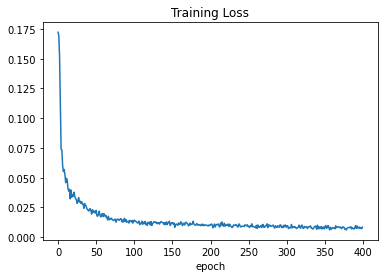

In [ ]:
plt.plot(loss_)
plt.title("Training Loss")
plt.xlabel("epoch")
plt.show()

In [ ]:
def evaluation(dataloader):
    
    predictions = torch.tensor([], dtype=torch.float) # 예측값을 저장하는 텐서
    actual = torch.tensor([], dtype=torch.float) # 실제값을 저장하는 텐서
        
    with torch.no_grad():
        model.eval() # 평가를 할 때에는 .eval() 반드시 사용해야 한다.
        for data in dataloader:
            inputs, values = data
            outputs = model(inputs)

            predictions = torch.cat((predictions, outputs), 0) # cat을 통해 예측값을 누적
            actual = torch.cat((actual, values), 0) # cat을 통해 실제값을 누적
    
    predictions = predictions.numpy() # 넘파이 배열로 변경
    actual = actual.numpy() # 넘파이 배열로 변경
    rmse = np.sqrt(mean_squared_error(predictions, actual)) # sklearn을 이용하여 RMSE 계산
    
    return rmse  

# 평가 시 .eval()을 사용해야 하는 이유
# 평가 시에는 온전한 모델로 평가를 해야하는데 .eval()이 아닌 .train()인 경우 드랍아웃이 활성화 되어 있다.
# 따라서 드랍아웃이나 배치 정규화 등과 같이 학습 시에만 사용하는 기술들을 평가 시에는 비활성화 해야만 한다.

In [ ]:
train_rmse = evaluation(trainloader) # 학습 데이터의 RMSE
test_rmse = evaluation(testloader) # 시험 데이터의 RMSE

print("Train RMSE: ",train_rmse)
print("Test RMSE: ",test_rmse)

# 예시를 위한 단순 비교입니다. 실제 연구에서는 디테일한 비교가 필요합니다.
# 데이터를 무작위로 나누고 모델의 초기값도 random initial parameter를 사용했기 때문에 학습을 할 때 마다 결과가 다르게 나올 수 있습니다.
# 이 강의에서는 학습의 흐름(for문)과 모델(Regressor) 부분을 주의 깊게 보시면 됩니다.

Train RMSE:  0.06694306
Test RMSE:  0.12023918


# **5.2>  활성화 함수**

# **5.2.1) 활성화 함수가 필요한 이유**

# **5.2.2) 선형함수**

# **5.2.3) 시그모이드(sigmoid) 함수**

torch.sigmoid() / nn.Sigmoid()

모든 입력값에 대해 0과 1 사이로 변환하는 역할을 함

# **5.2.4) tanh 함수**

torch.tanh() / nn.Tanh()

시그모이드 함수와 형태는 유사하지만 -1과 1 사이의 값을 취할 수 있음

# **5.2.5) ReLu 함수**

torch.nn.functional.relu() / nn.ReLu()

두 개의 직선을 이어 만든 것으로 비선형 함수지만 선형과 매우 유사한 성질을 가지고 있음. 따라서 계산이 쉽고 미분도 쉽게 풀 수 있다.
모델 최적화에 유용한 선형적 성질들을 보존하고 있어서 최적화를 쉽게 할 수 있다.
가장 널리 사용. 성능이 매우 좋음.

# **5.2.6) Softmax 함수**

torch.nn.functional.softmax() / nn.Softmax()

벡터 x에 대하여 모든 성분이 항상 양수이며, 그 합이 1이 되도록 변환한다.
따라서 음수값이 나오더라도 항상 양수가 나오도록 지수 함수를 이용한 함수.
벡터 형태로 예측값이 나오는 다중 분류문제에서 자주 사용

# **5.2.7) 기타 활성화 함수**

nn.ELU()

nn.LeakyReLU()

nn.LogSigmoid()

nn.SELU()

..

# **5.3> 손실 함수**

# **5.3.1) MAE**

torch.nn.L1Loss

유사도, 거리측정, 회귀 문제 등에 많이 사용되는 손실 함수

# **5.3.2) MSE**

torch.nn.MSELoss

MAE와 함께 유사도, 거리측정, 회귀 문제 등에 많이 사용되는 손실함수

# **5.3.3) Cross Entropy Loss**

torch.nn.CrossEntropyLoss

주로 다중 분류 문제에서 사용.
유의할 점은 파이토치에서는 예측값은 벡터 형태, 타깃값은 라벨 형태로 세팅해야 에러가 나지 않는다.

# **5.3.4) 기타 손실 함수**

nn.BCELoss

nn.NLLoss

nn.KLDivLoss

..

# **5.4> 최적화 기법**

손실 함수값이 가장 작게 나오게 하는 변수(w*)를 찾는 것이 목적

경사하강법(gradient descent)

경사를 의미하는 미분을 이용해 w를 업데이터 하는데, 이때 하강에 대한 보폭을 정해주는 값이 학습률(learning rate 또는 step size)이다.

# **5.4.1) 확률적 경사하강법(SGD)**

torch.optim.SGD

속도와 메모리를 개선하기 위해 데이터를 나눠서 학습하는 방법으로 학습을 진행하는데
나눠진 데이터 세트를 미니 배치(mini-batch)라고 하며, 미니 배치를 이용해 경사하강법을 진행하는 것을 확률적 경사하강법(stochastic gradient descent:SGD)라고 한다.

일반 경사하강법과 다른 점은 데이터 전체를 한 번에 사용하는지 나눠서 사용하는 지의 차이

확률적이라고 하는 이유는 미니 배치를 나눌 때 데이터를 무작위로 섞어서 나누기 때문.

In [ ]:
optimizer = torch.optim.SGD(model.parameters(), lr=0.01)

# **5.4.2) 다양한 최적화 기법**

경사하강법과 SGD는 학습률이 고정되어 있기 때문에 계산이 비효율적일 수 있음

더 효율적이 최적호를 위해 모멘텀+스케줄링이나 Adam을 사용

기타: torch.optim.Adadelta

torch.optim.Adagrad

torch.optim.RMSprop

...

In [ ]:
#momentum
optimizer = torch.optim.SGD(model.parameters(), lr=0.01, momentum=0.9)

In [ ]:
#Adam
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

# **5.4.3) 스케줄링**

MultiplicativeLR

LambdaLR

StepLR

MultiStepLR

ExponentialLR

CosineAnnealingLR

In [ ]:
optimizer = torch.optim.SGD(model.parameters(), lr=0.1, momentum=0.9)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=30, gamma=0.1)
#중략
for epoch in range(400):
  running_loss = 0.0
  for data in trainloader:
    inputs, values = data
    optimizer.zero_grad()
    outputs = model(inputs)
    loss = criterion(outputs, values)
    loss.backward()
    optimizer.step()
    #중략
  scheduler.step()

# **5.4.4) MADGRAD**

madgrad.MADGRAD(모델 변수, lr=학습률(default:0.01), momentum=모멘텀지수(default:0.9), weight_decay=L2페널티(default:0))

In [ ]:
!pip install madgrad

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import madgrad
optimizer = madgrad.MADGRAD(model.parameters())

# **5.5> 교차 검증**

# **5.5.1) 교차 검증을 통한 집값 예측 평가 모델 평가**

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
import torch
from torch import nn, optim
from torch.utils.data import DataLoader, Dataset
import torch.nn.functional as F
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt

In [ ]:
#데이터 프레임을 넘파이 배열로 만들기
df = pd.read_csv('../data/reg.csv', index_col=[0])

X = df.drop('Price', axis=1).to_numpy()
Y = df['Price'].to_numpy().reshape((-1, 1))

In [ ]:
#텐서 데이터 만들기
class TensorData(Dataset):
  def __init__(self, x_data, y_data):
    self.x_data = torch.FloatTensor(x_data)
    self.y_data = torch.FloatTensor(y_data)
    self.len = self.y_data.shape[0]

  def __getitem__(self, index):
    return self.x_data[index], self.y_data[index]

  def __len__(self):
    return self.len

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.7)

trainset = TensorData(X_train, Y_train)
testset = TensorData(X_test, Y_test)

testloader = torch.utils.data.DataLoader(testset, batch_size=32, shuffle=False)

In [ ]:
#모델 구축
class Regressor(nn.Module):
  def __init__(self):
    super().__init__()
    self.fc1 = nn.Linear(13, 50, bias=True)
    self.fc2 = nn.Linear(50, 30, bias=True)
    self.fc3 = nn.Linear(30, 1, bias=True)

  def forward(self, x):
    x = self.fc1(x)
    x = self.fc2(x)
    x = self.fc3(x)
    return x

In [ ]:
#손실함수와 교차 검증 정의
kfold = KFold(n_splits=3, shuffle=True)
criterion = nn.MSELoss()

In [ ]:
#평가 함수 정의
def evaluation(dataloader):
  predictions = torch.tensor([], dtype=torch.float)
  actual = torch.tensor([], dtype=torch.float)

  with torch.no_grad():
    model.eval()
    for data in dataloader:
      inputs, values = data
      outputs = model(inputs)

      predictions = torch.cat((predictions, outputs), 0)
      actual = torch.cat((actual, values), 0)

    predictions = predictions.numpy()
    actual = actual.numpy()

    rmse = np.sqrt(mean_squared_error(predictions, actual)) # sklearn을 이용하여 RMSE 계산

    model.train()
    
    return rmse

In [ ]:
#교차 검증을 이용한 학습 및 평가
validation_loss = []
for fold, (train_idx, val_idx) in enumerate(kfold.split(trainset)):

  train_subsampler = torch.utils.data.SubsetRandomSampler(train_idx)
  val_subsampler = torch.utils.data.SubsetRandomSampler(val_idx)

  trainloader= torch.utils.data.DataLoader(trainset, batch_size=32, sampler=train_subsampler)
  valloader = torch.utils.data.DataLoader(trainset, batch_size=32, sampler=val_subsampler)

  model = Regressor()
  optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-7)

  for epoch in range(400):
    for data in trainloader:
      inputs, values = data
      optimizer.zero_grad()

      outputs = model(inputs)
      loss = criterion(outputs, values)
      loss.backward()
      optimizer.step()
  
  train_rmse = evaluation(trainloader)
  val_rmse = evaluation(valloader)

  print("k-fold", fold, "Train Loss: %.4f, Validation Loss: %.4f"%(train_rmse, val_rmse))
  
  validation_loss.append(val_rmse)

k-fold 0 Train Loss: 0.1088, Validation Loss: 0.1459
k-fold 1 Train Loss: 0.1076, Validation Loss: 0.1435
k-fold 2 Train Loss: 0.1232, Validation Loss: 0.1387


In [ ]:
#검증 점수 산출
validation_loss = np.array(validation_loss)
mean = np.mean(validation_loss)
std = np.std(validation_loss)

print("Validation Score: %.4f, +- %.4f" % (mean, std))

Validation Score: 0.1427, +- 0.0030


In [ ]:
#모델 평가
trainloader = torch.utils.data.DataLoader(trainset, batch_size=32, shuffle=False)

train_rmse = evaluation(trainloader)
test_rmse = evaluation(testloader)

print("Train RMSE: %.4f" % train_rmse)
print("Test RMSE: %.4f" % test_rmse)

Train RMSE: 0.1285
Test RMSE: 0.1374


# **5.6> 모델 구조 및 가중치 확인**

# **5.6.1) 모델 구조**

In [ ]:
!pip install torchsummary

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import torch
from torch import nn
import torch.nn.functional as F
from torchsummary import summary

In [ ]:
#모델 구축
class Regressor(nn.Module):
  def __init__(self):
    super().__init__()
    self.fc1 = nn.Linear(13, 50, bias=True)
    self.fc2 = nn.Linear(50, 30, bias=True)
    self.fc3 = nn.Linear(30, 1, bias=True)
    self.dropout = nn.Dropout(0.5)

  def forward(self, x):
    x = F.relu(self.fc1(x))
    x = self.dropout(F.relu(self.fc2(x)))
    x = F.relu(self.fc3(x))
    
    return x

In [ ]:
model = Regressor()
print(model)

Regressor(
  (fc1): Linear(in_features=13, out_features=50, bias=True)
  (fc2): Linear(in_features=50, out_features=30, bias=True)
  (fc3): Linear(in_features=30, out_features=1, bias=True)
  (dropout): Dropout(p=0.5, inplace=False)
)


# **5.6.2) 모델 변수**

In [ ]:
for parameter in model.parameters():
  print(parameter.size())

torch.Size([50, 13])
torch.Size([50])
torch.Size([30, 50])
torch.Size([30])
torch.Size([1, 30])
torch.Size([1])


In [ ]:
print(model.fc1.weight.size(), model.fc1.bias.size())

torch.Size([50, 13]) torch.Size([50])


In [ ]:
for name, param in model.named_parameters():
  print(name, param.size())

fc1.weight torch.Size([50, 13])
fc1.bias torch.Size([50])
fc2.weight torch.Size([30, 50])
fc2.bias torch.Size([30])
fc3.weight torch.Size([1, 30])
fc3.bias torch.Size([1])


In [ ]:
model = model.cuda()
summary(model, (10, 13))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1               [-1, 10, 50]             700
            Linear-2               [-1, 10, 30]           1,530
           Dropout-3               [-1, 10, 30]               0
            Linear-4                [-1, 10, 1]              31
Total params: 2,261
Trainable params: 2,261
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.01
Params size (MB): 0.01
Estimated Total Size (MB): 0.02
----------------------------------------------------------------
